In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
import json
import pickle

In [3]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

# style 설정은 꼭 폰트설정 위에서 합니다.
# style 에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 한글이 깨집니다.
plt.style.use("seaborn")
# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

C:\Users\Lee\AppData\Local\Temp\ipykernel_1912\3581263816.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
C:\Users\Lee\AppData\Local\Temp\ipykernel_1912\3581263816.py:37: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("retina")


In [4]:
df = pd.read_json('C:/Users/Lee/Desktop/개인프로젝트/bertopic_sentiment_STS/신문기사_train_original/train_original.json', encoding='UTF-8')
df_doc = df.documents
type(df_doc)


pandas.core.series.Series

<AxesSubplot: xlabel='category'>

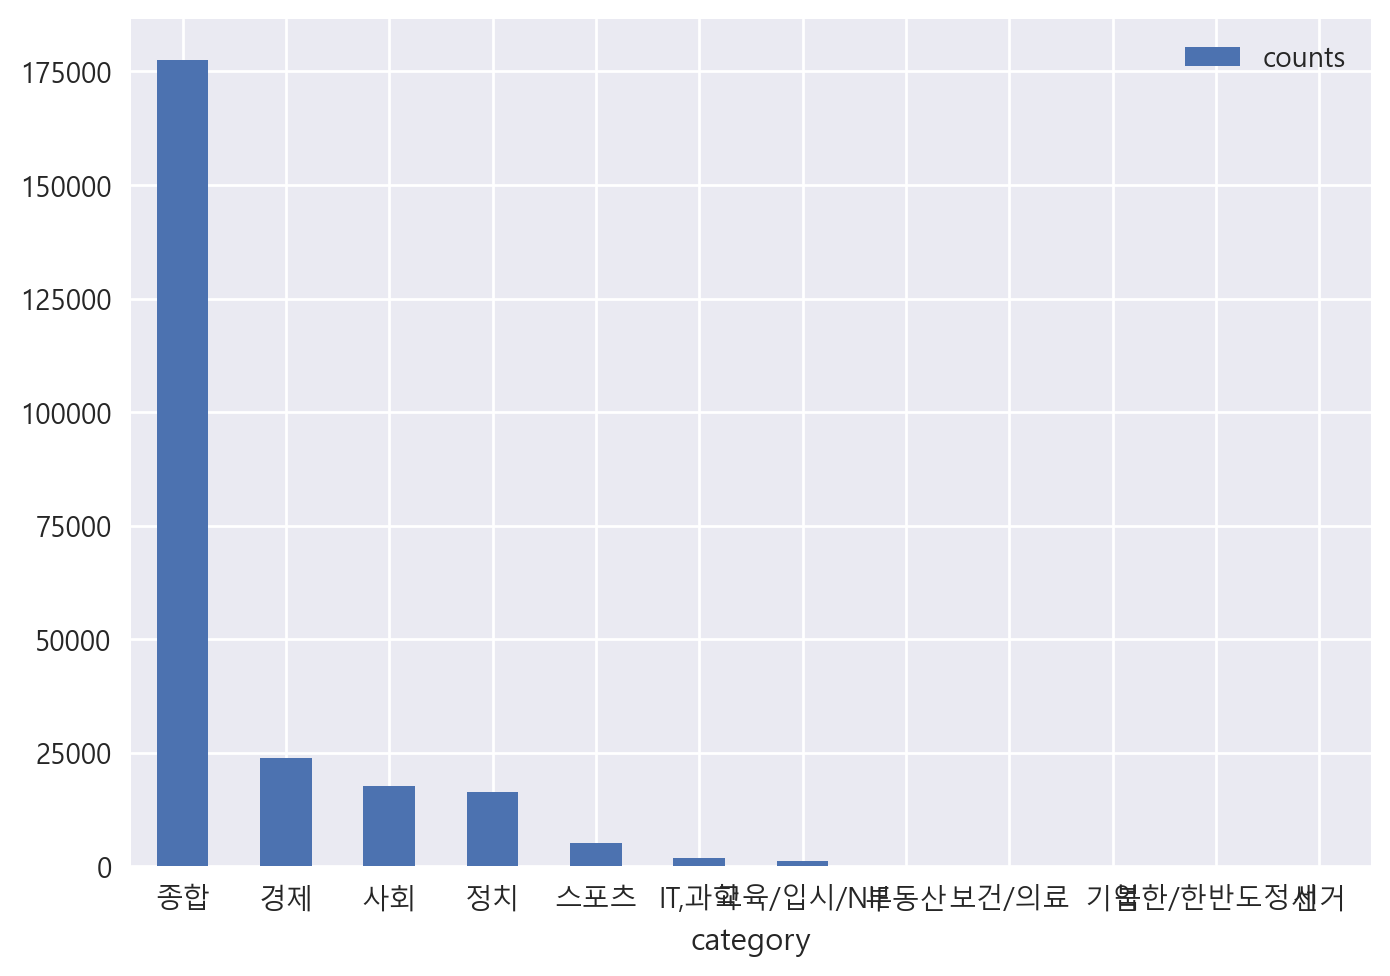

In [5]:
#뉴스 기사 문서 별 주제 갯수
df_doc = pd.json_normalize(df_doc)
df_doc.category.value_counts()
categories = pd.DataFrame({'category': df_doc.category.value_counts().index.tolist(),
             'counts': df_doc.category.value_counts().values.tolist()})

categories.plot.bar(x='category', 
                         y='counts', rot=0)

In [12]:
df_doc.category.value_counts()

종합           177558
경제            23938
사회            17650
정치            16389
스포츠            5174
IT,과학          1931
교육/입시/NIE      1190
부동산              74
보건/의료            55
기업               17
북한/한반도정세          5
선거                2
Name: category, dtype: int64

In [6]:
#json 파일 학습 할 데이터 솎아내기
df_doc = df_doc[['category', 'text']]
df_doc.head(5)

def text2list(row_text):
    sentences = []
    for i in range(len(row_text)):
        for j in range(len(row_text[i])):
            sentences.append(row_text[i][j]['sentence'])        
    return sentences

df_doc['text'] = df_doc['text'].apply(text2list)

def sentence2doc(SentenceList):
    return ' '.join(SentenceList)

df_doc['text'] = df_doc['text'].apply(sentence2doc)

categories = df_doc['category'].value_counts().index.tolist()

print(categories)

['종합', '경제', '사회', '정치', '스포츠', 'IT,과학', '교육/입시/NIE', '부동산', '보건/의료', '기업', '북한/한반도정세', '선거']


In [7]:
#카테고리별로 문서 나누기
def categories_split(df, categories):
    #각 category의 문서들을 리스트형태로
    split_categories_df = []
    for i in range(len(categories)):
        i = df[df['category'] == categories[i]]
        split_categories_df.append(i)    
    return split_categories_df

split_categories_df = categories_split(df_doc, categories)


#각 분야의 문서들을 랜덤으로 섞는다.
for i in range(len(split_categories_df)):
    split_categories_df[i] = split_categories_df[i].sample(frac=1)

# ['종합문서의 DataFrame', '경제문서의 DataFrame', '정치문서의 DataFrame', ...]
type(split_categories_df)

list

In [2]:
#저장 split_categories_df

#with open('split_categories_df.pkl', 'wb') as f:
#    pickle.dump(split_categories_df, f, pickle.HIGHEST_PROTOCOL)

# load

with open('split_categories_df.pkl', 'rb') as f:
    split_categories_df = pickle.load(f)

In [9]:
#각 카테고리의 문서 수를 줄인다.
df_generals = split_categories_df[0][:1900]
df_economy = split_categories_df[1][:1100]
df_society = split_categories_df[2][:1100]
df_politics = split_categories_df[3][:500]
df_sports = split_categories_df[4][:100]
df_IT_Science = split_categories_df[5][:150]
df_edu = split_categories_df[6][:100]
df_estate = split_categories_df[7]
df_medical = split_categories_df[8]
df_business = split_categories_df[9]
df_Korean_Peninsula = split_categories_df[10]
df_vote = split_categories_df[11]

df = pd.concat([df_generals, df_economy, df_society, df_politics,
              df_IT_Science, df_edu, df_estate, df_medical, df_business,
              df_Korean_Peninsula, df_vote], axis=0, ignore_index=True)

In [4]:
print(df.shape, df.text.str.len().mean())

(5003, 2) 1029.152508494903


In [2]:
#최종 학습할 데이터 저장 df

# with open('train_topic_data.pkl', 'wb') as f:
#     pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

#load
with open('train_topic_data.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
import re
#기본 전처리
#Function to remove emoji
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

#Clean some basic characters
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

#Remove numeric
def remove_num(texts):
    output = re.sub(r'\d+', '', texts )
    return output

#function to unify whitespaces
def unify_whitespaces(text):
    cleaned_string = re.sub(' +', ' ', text )
    return cleaned_string

#function to remove punctuation
def remove_punctuation(text):
    result = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',',') )
    return result
#Aplying all the cleaning util methods
def cleaning(df, docs_clean):
    df_processed = df.copy()
    df_processed[docs_clean] = df_processed[docs_clean].apply(clean)
    df_processed[docs_clean] = df_processed[docs_clean].apply(deEmojify)
    df_processed[docs_clean] = df_processed[docs_clean].apply(remove_num)
    df_processed[docs_clean] = df_processed[docs_clean].apply(remove_punctuation)
    df_processed[docs_clean] = df_processed[docs_clean].apply(unify_whitespaces)
    return df_processed

In [5]:
df = cleaning(df, 'text')

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Mecab
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

In [7]:
#정해진 형태소에 token길이가 1인 것도 포함
class CustomTokenizer:
    def __init__(self, tagger, stop_words, tags=None):
        self.tagger = tagger
        self.stop_words = stop_words
        self.tags = tags
    def __call__(self, document):
        if tags == None:
            word_tokens = self.tagger.morphs(document)
        else:
            word_tokens = []
            for word in mecab.pos(document):
                if word[1] in self.tags:
                    word_tokens.append(word[0])
                
        result = [word for word in word_tokens \
                  if word not in self.stop_words]
        return result
        

In [8]:
#불용어 사전
stop_words_f ="./stopwords.txt"
with open(stop_words_f, "r", encoding='utf-8') as f:
    stop_words = f.readlines()
    stop_words = [stop_word.strip() for stop_word in stop_words]

In [9]:
#토큰처리할 형태소
tags = ['NNG', 'NNP','NP','NNB' ]

custom_tokenizer = CustomTokenizer(mecab, stop_words, tags)
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_features= 3000)

In [10]:
#BERTopic
from bertopic import BERTopic
#Dimension reduction
from umap import UMAP

In [11]:
#Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  )
# random_state=42 성능 높이기위해 seed를 제외

model = BERTopic(embedding_model="sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens", \
                 vectorizer_model=vectorizer,
                 umap_model=umap_model,
                 nr_topics= 50,
                 top_n_words= 15,
                 calculate_probabilities=True)

In [12]:
topics, probs = model.fit_transform(df['text'])

print(topics[:5]  ,len(topics))

[-1, -1, 3, -1, -1] 5003


In [16]:
# 저장 및 불러오기
#model.save("news_documents_topic_model")

model = BERTopic.load("news_documents_topic_model")

In [13]:
#토픽 주제 정보
model.get_topic_info()

,Topic,Count,Name
0,-1,2646,-1_지역_사업_말_기자
1,0,379,0_문화_지역_사업_시
2,1,281,1_금리_하락_감소_분기
3,2,127,2_병원_의료_환자_치료
4,3,95,3_일본_당_대통령_국회
5,4,95,4_증가_대비_전년_지난해
6,5,88,5_학생_교육_학교_프로그램
7,6,87,6_기술_기업_혁신_산업
8,7,85,7_안전_사고_발생_화재
9,8,77,8_지원_사회_이웃_활동


In [18]:
# Visualize top topic keywords
model.visualize_barchart(top_n_topics=50, n_words = 15)

In [19]:
#get_topic(0) 토픽 0에 대한 상위 용어 10개
model.get_topic(0)

[('문화', 0.012359786950209395),
 ('지역', 0.012090029360654479),
 ('사업', 0.011662364316091686),
 ('시', 0.01013924137235877),
 ('대구', 0.009594737440327182),
 ('축제', 0.009090737760016183),
 ('기자', 0.008964319021204351),
 ('도시', 0.008649378412134897),
 ('대표', 0.008614674768238566),
 ('중', 0.008384034467972302),
 ('교육', 0.00836998277520373),
 ('충북', 0.008340490867799213),
 ('선정', 0.008326010694848816),
 ('계획', 0.00810264541437027),
 ('추진', 0.00808717369918763)]

In [20]:
model.probabilities_[0]

array([0.00231231, 0.00214931, 0.0024165 , 0.0017995 , 0.00441731,
       0.00299669, 0.00665157, 0.00403146, 0.00999859, 0.00376435,
       0.00388646, 0.00290563, 0.00198125, 0.00416309, 0.00113626,
       0.00425019, 0.00144929, 0.00529589, 0.00135805, 0.00681304,
       0.00216711, 0.0013683 , 0.00195352, 0.00533024, 0.00397315,
       0.00243796, 0.00820836, 0.00359428, 0.00377904, 0.0015305 ,
       0.00197469, 0.00147383, 0.00150428, 0.00541087, 0.00270714,
       0.00221803, 0.00379227, 0.0014662 , 0.00176489, 0.00299178,
       0.00152361, 0.00266243, 0.00236328, 0.00318064, 0.0020698 ,
       0.00228068, 0.001626  , 0.00250597, 0.00682682, 0.0018176 ])

In [24]:
df['text'].iloc[2]

"일 경제도발에 車노조 '투쟁 수위' 조절 기류 김상아 현대자동차 노조가 일 “회사가 노조의 주요 핵심요구에 대해 전향적으로 수용하고 일괄 제시하면 추석 전 임단협 조기 타결을 추진할 것”이라고 밝혔다 여름휴가 전후로 일본의 한국 화이트리스트(수출심사 우대국) 제외 등 예상 밖 변수가 커지자 노조가 휴가에 복귀한 뒤 교섭의 장을 열어놓는 등 투쟁 수위를 저울질하는 분위기다 현대차 노조는 이날 오전 하부영 지부장 명의로 긴급성명서를 내고 이 같은 입장을 전했다 노조는 “지난달 말 사측 최고경영진에게 지난 년간의 구태의연한 교섭 방식에서 벗어나 추석 전에 일괄 제시할 것을 강력히 촉구했다”면서 “이낙연 총리는 지난 일 국무회의에서 노조에는 파업 자제를 회사에는 전향적으로 협상에 임해 해결책을 찾아 달라고 했다 이는 지난달 일 노조의 일괄제시 요구에 대한 문재인정부의 응답이라고 생각한다”고 밝혔다 이어 “핵심 요구를 사측이 전향적으로 수용하고 일괄 제시한다면 시기에 연연하지 않고 조속히 타결할 수도 있다”고 강조했다 노조는 “그러나 일본의 수출규제 경제도발을 강력히 규탄하지만 이를 악용해 노동자의 합법적이고 정당한 투쟁을 제한하거나 왜곡하는 행위에는 단호히 반대한다”며 “올해 임단협에서 만여명의 조합원과 전체 노동자의 생존권 쟁취를 위해 최선을 다하겠다”고 전했다 노조는 일 쟁의대책위원회 차 회의를 열고 향후 교섭일정과 투쟁일정을 결정하기로 했다 앞서 현대차 노사는 지난 월일 상견례를 시작으로 일 가까이 차례에 걸쳐 교섭을 가졌으나 합의점을 찾지 못했다 지난 일 회사가 노조의 일괄제시 요구를 거부하자 노조는 곧바로 교섭 결렬을 선언했다 노조는 지난달 일 조합원 찬반투표에서 재적대비 %의 찬성으로 파업을 가결한 데 이어 지난 일 중앙노동위원회로부터 조정중지 결정을 받아 합법적인 파업권을 확보한 상태다 노조는 올해 임단협에서 기본급 만원(% 호봉승급분 제외) 인상과 당기 순이익 %를 성과급으로 지급 상여금 통상임금 적용 등을 요구했다 또 정년을 현재 만 세에서 국민연금

In [22]:
#학습한 5000 문서중 doc_n 와 밀접한 토픽의 확률 분포
doc_n = 2
model.visualize_distribution(model.probabilities_[doc_n], min_probability=0.02)

In [1]:
# Visualize intertopic distance
model.visualize_topics()

NameError: name 'model' is not defined

In [26]:
# Visualize term rank decrease
model.visualize_term_rank()

In [27]:
# Visualize similarity using heatmap
model.visualize_heatmap()

In [35]:
print(np.argmax(model.probabilities_[3]))
# Get probabilities for all topics
print(model.probabilities_[3])

6
[0.01246001 0.00767814 0.01195984 0.00821531 0.01063487 0.02234956
 0.13247133 0.01641261 0.04299444 0.01043434 0.01844396 0.04401297
 0.01081265 0.01659853 0.00619232 0.02568993 0.00712954 0.02594612
 0.00724017 0.02563037 0.00814227 0.00646192 0.00840794 0.01311182
 0.01640829 0.00903777 0.02410649 0.02199744 0.01125042 0.00859809
 0.00930964 0.00694365 0.0072388  0.01532367 0.02017411 0.01937557
 0.01918938 0.00807099 0.0083458  0.01015496 0.00871868 0.01880846
 0.01212904 0.00905834 0.01427549 0.01051502 0.00654483 0.01437417
 0.02074777 0.01139561]


In [31]:
# Get the topic predictions
topic_prediction = model.topics_[:]
# Save the predictions in the dataframe
df['topic_prediction'] = topic_prediction
# Take a look at the data
df.head()

,category,text,topic_prediction
0,종합,'겨울왕국'가 개봉 일만에 만 관객을 끌어모았다 일 영화관입장권통합전산망 집계에 따...,-1
1,종합,국산 중형세단 부활 신호탄 기아자동차는 세대 K(사진)가 역대 자사 모델 가운데 역...,-1
2,종합,일 경제도발에 車노조 '투쟁 수위' 조절 기류 김상아 현대자동차 노조가 일 “회사가...,3
3,종합,SKT G 스마트 오피스 구현 SK텔레콤이 세대 이동통신(G)을 기반으로 한 ‘G ...,-1
4,종합,여성 존중 Vs 결국 살인 충북 년간 낙태사건 명 기소된 피의자 명 불과 뉴시스 ［...,-1


In [32]:
df.topic_prediction.value_counts()

-1     2646
 0      379
 1      281
 2      127
 3       95
 4       95
 5       88
 6       87
 7       85
 8       77
 9       58
 11      54
 10      54
 12      48
 14      47
 13      47
 15      43
 16      40
 17      34
 18      32
 19      28
 20      27
 21      26
 23      25
 22      25
 25      24
 24      24
 26      24
 27      23
 28      22
 30      21
 29      21
 32      20
 33      20
 31      20
 34      19
 35      18
 36      17
 37      17
 38      16
 40      15
 39      15
 44      14
 41      14
 42      14
 43      14
 45      13
 46      13
 47      13
 49      12
 48      12
Name: topic_prediction, dtype: int64

In [33]:
df.text[3]

'SKT G 스마트 오피스 구현 SK텔레콤이 세대 이동통신(G)을 기반으로 한 ‘G 스마트 오피스’ 솔루션을 일 공개했다 ‘스마트 오피스’는 G 통신과 인공지능(AI) 가상현실(VR) 증강현실(AR)을 융합해 사람과 사람(또는 사물)이 데이터를 송수신할 수 있고 데이터를 분석해 업무 효율성을 높인 사무실이다 SK텔레콤 직원이 AR 글라스를 착용하고 T 리얼 텔레프리즌스로 가상공간에서 회의를 하고 있다 SK텔레콤 제공 SK텔레콤은 서울 종로구 본사 사옥의 일부 부서를 최근 한 달 동안 인근의 다른 장소로 옮겨 ‘G 스마트 오피스’ 구현을 시도했다 SK텔레콤은 스마트 오피스의 천장 주차장 복도 지능형 CCTV AI자판기 심지어 화장실 문고리까지 사물인터넷(IoT) 센서를 설치했다 이 센서로 공간의 온도와 밝기 습도 등의 환경 기기 상태 이용 빈도 등 각종 정보를 실시간으로 수집했다 이 데이터를 활용해 최적의 업무 환경을 제공할 수 있도록 에어컨 등 각종 기기를 제어하고 공간 사용 정보를 분석해 공간을 재배치했다 SK텔레콤은 이날 또한 스마트오피스 솔루션 종을 공개했다 ‘G Walking-through 시스템’은 영상분석 기술과 AI를 활용해 카메라가 얼굴을 인식해 출입증이나 지문인식 없이 출입할 수 있도록 한 설비다 AI가 얼굴의 피부상태 골격 등 개의 특징을 찾아내 출입이 가능한 인물인지 확인한다 SK텔레콤 관계자는 “일란성 쌍둥이도 구별한다”고 말했다 ‘G VDI 도킹’은 노트북이나 PC 없이도 패드에 스마트폰을 꽂으면 가상 데스크톱 환경(VDI Virtual Desktop Infrastructure)과 즉시 연동돼 업무를 볼 수 있는 시스템이다 ‘T 리얼 텔레프리즌스’는 VR과 AR을 융합해 회의 참가자가 동시 접속해 실제 같은 방에 모여 있는 것처럼 느낄 수 있다 AR 글라스로 가상공간에서 대용량 영상자료를 함께 보거나 D 설계도면을 펼쳐서 회의할 수 있다 정옥재 기자 '

In [40]:
#New Data
new_text = "서울중앙지법 형사27부(재판장 김옥곤)는 15일 직권남용 혐의를 받은 이 연구위원에게 무죄를 선고했다. 재판부가 무죄를 선고한 내용은 ‘김학의 불법 출금 의혹’이 불거져 관련한 검찰 수사가 진행되던 2019년 당시 대검찰청 반부패강력부가 수사를 무마하기 위한 외압을 행사했다는 내용이다. 당시 수원지검 안양지청 수사팀이 김 전 차관 불법 출금 사건을 수사하다 이규원 검사(당시 대검 과거사진상조사단 소속)가 가짜 사건번호로 김 전 차관 출국을 막았다는 의혹을 발견했는데, 당시 대검 반부패강력부장이었던 이 연구위원이 배용원 당시 안양지청 차장검사에게 전화를 걸어 수사팀 수사를 막았다는 것이다. 당시 안양지청 수사팀의 일원이었던 장준희 부산지검 부부장검사가 이같은 사실을 외부로 알리는 ‘공익신고’에 나섰고 이후 관련 수사가 급물살을 탔다.이날 재판부는 이 연구위원의 행위만으로 수사 방해 결과가 발생했을 것이라 단정할 수 없다고 판단했다. 재판부는 “이 연구위원의 외에도 당시 윤대진 법무부 검찰국장의 전화 연락, 법무부의 경위 파악 지시, 대검과 안양지청 사이 의사소통 부재, 안양지청 지휘부의 자의적 판단에 따른 수사 중단 결정 등이 경합되어 발생한 결과라고 보는 것이 합리적”이라며 “반부패강력부장의 직권을 남용해 위법·부당한 압력을 행사했다는 공소사실이 충분히 증명됐다고 볼 수 없다”고 판단했다. 당시 법무·검찰 고위 인사들의 의사 결정 과정을 종합적으로 판단하지 않는 이상, 이 연구위원에 대해서만 유죄로 판결하기 어렵다는 취지다.그러나 이 연구위원을 재판에 넘긴 뒤 당시 법무·검찰 고위층 인사에 대한 수사는 사실상 공전 상태에 머물러 있다. 2021년 3월 고위공직자범죄수사처(공수처)는 검찰로부터 이 사건을 이첩받았으나 ‘수사인력 부족’을 이유로 사건을 검찰에 넘겼다. 검찰은 그 해 5월 이성윤 연구위원만 재판에 넘기면서 일명 ‘소윤’으로 불리는 윤대진 전 검찰국장 등을 공수처에 이첩했다. 윤 전 국장은 이현철 당시 안양지청장에게 전화를 걸어 ‘왜 이규원 검사 수사를 하냐’며 수사에 압력을 행사했다는 의혹을 받는다. 공수처가 사건을 살펴봤으나 ‘공익신고자’ 장준희 부부장검사가 공수처 출석을 거부하는 등 사유를 들어 지난달 윤 전 검찰국장·조국 당시 민정수석·박상기 법무부 장관 등 ‘수사외압 의혹’ 사건을 검찰에 넘겼다. 현재 사건은 수원지검이 들고 있는 상태다. 윤석열 당시 검찰총장 등이 ‘눈에 가시’처럼 여기던 이성윤 연구위원을 재판에 넘긴 뒤, 윤 전 국장 등에 대한 수사에는 소극적인 태도를 보인 것 아니냐는 비판이 법조계 안팎에서 나왔다.수도권 검찰청의 한 부장검사는 “검찰 항소가 예상되는 상황에서 굳이 무리하게 수사를 이어갈 이유가 없다. 확실한 판결 결과가 나올 때까지 사건을 묵힐 가능성이 높다”며 “윤 전 국장이 윤 대통령과 친분이 두터워 어차피 수사하기 부담스러웠을 것”이라고 말했다.이 연구위원은 이날 무죄 판결을 받은 뒤 “‘윤석열 정치 검찰’이 특정 세력이나 사익을 위해 수사하고 기소한 것이 아닌가 심히 의심이 든다”고 말했다. 수원지검 수사팀은 “검찰은 헌법상 적법 절차 원칙을 위반하고 수사를 부당하게 중단시킨 공직자들에게 죄에 상응하는 형이 선고될 수 있도록 항소를 제기할 예정”이라고 밝혔다"

In [41]:

#Find topics
num_of_topics = 2
similar_topics, similarity = model.find_topics(new_text, top_n = num_of_topics)

print(f'The top {num_of_topics} similar topics are {similar_topics}, and the similarities are {np.round(similarity,2)}')

The top 2 similar topics are [38, 32], and the similarities are [0.16 0.15]


In [42]:
similar_topics

[38, 32]

In [43]:
model.visualize_barchart(topics= similar_topics, n_words = 15)

In [44]:
# Print the top keywords for the top similar topics
for i in range(num_of_topics):
  print(f'The top keywords for topic {similar_topics[i]} are:')
  print(model.get_topic(similar_topics[i]))

The top keywords for topic 38 are:
[('검찰', 0.07038815708779637), ('진상', 0.03984897300539325), ('북한', 0.03419728785836832), ('개혁', 0.03143354813646908), ('총리', 0.02651610001520234), ('결정', 0.02628784994217468), ('규명', 0.026006330058452338), ('입장', 0.025110197259756235), ('광주', 0.024833058628992866), ('국민', 0.02390115375642857), ('청와대', 0.0235187979725025), ('강조', 0.023416569713238636), ('기념식', 0.023128004344978307), ('관할', 0.021919289959773804), ('장관', 0.021870255515966653)]
The top keywords for topic 32 are:
[('학원', 0.029127716710102322), ('공무원', 0.025388353692965982), ('건축', 0.023025379052014922), ('울산', 0.02222232899875717), ('갈등', 0.021234447932058923), ('공원', 0.020668376017433158), ('부산시', 0.01921748859453642), ('농산물', 0.01874895789216755), ('터널', 0.01800781057061044), ('민간', 0.01758586250595939), ('곳', 0.017254684871689265), ('수입', 0.016614990324841063), ('채용', 0.01626066955780187), ('조선대', 0.01611939629964292), ('시', 0.01568577536637515)]
